# Eccentric Comets (HERMES tutorial)
Highly eccentric comets play a role in many areas of research, but they are difficult to study since they require high resolution when passing close to the sun. If one uses a single timestep throughout the simulation, either this perihelion passage of the comet will be inaccurately resolved, or the simulation will take much longer than needed due to the tiny timestep used at all points in the orbit. 

HERMES, a hybrid integration scheme which combines the WHFAST and IAS15 algorithms, is well suited to study this problem, since the algorithm will automatically switch to IAS15 during perihelion passage but otherwise will use a large WHFAST timestep.

In this example we integrate Neptune plus N-eccentric comets orbiting around the sun. 

In [1]:
import rebound
import numpy as np

First let's choose the basic properties required for the HERMES integrator to run correctly. In particular, we are:  
* Adding comets as *semi-active* bodies, which means they can influence/be influenced by other active bodies, but are invisible to each other. This is done by setting testparticle_type to 1. Setting testparticle_type to 0 would indicate that we are adding comets as *test* bodies.
* Merging colliding bodies perfectly inelastically.
* Remove particles that leave our pre-defined box.
* Track the energy lost due to ejections or collisions.  

In [2]:
sim = rebound.Simulation()

#integrator options
sim.integrator = "hermes"
sim.ri_hermes.solar_switch_factor = 30.    #boundary for close encounters with sun. Units of physical radius.
sim.ri_hermes.hill_switch_factor = 4.       #Setting HSF "floor", adaptive HSF routine is active by default.
sim.dt = 4
sim.testparticle_type = 1

#collision and boundary options
sim.collision = "direct"
sim.collision_resolve = "merge"
sim.collision_resolve_keep_sorted = 1
sim.boundary = "open"
boxsize = 200.
sim.configure_box(boxsize)
sim.track_energy_offset = 1

#simulation time
tmax = 1e4

Now that the preliminary setup is complete, it's time to add some particles to the system! When using the HERMES integrator it's always important to add active bodies first and semi-active bodies later. The "sim.N_active" variable distinguishes massive bodies from semi-active/test bodies.

In [3]:
#massive bodies
sim.add(m=1., r=0.005)                 #sun
a_neptune = 30.05
sim.add(m=5e-5,r=2e-4,a=a_neptune,e=0.01)  #neptune

sim.N_active = sim.N

Now, let's create some comets! For this simple example we are assuming that all comets have the same mass and radius. Other, more complicated choices are certainly possible. 

In [4]:
#semi-active bodies
n_comets = 100
a = np.random.random(n_comets)*10 + a_neptune
e = np.random.random(n_comets)*0.1 + 0.8
inc = np.random.random(n_comets)*np.pi/2.
m=1e-14
r=1e-7

for i in xrange(0,n_comets):
    rand = np.random.random()*2*np.pi
    sim.add(m=m, r=r, a=a[i], e=e[i], inc=inc[i], Omega=0, omega=rand, f=rand)

Finally, since the integrator defaults to the WHFAST algorithm we need to move to the COM frame. In addition, it is always good practice to monitor the change in energy over the course of a simulation, which requires us to calculate it before and after the simulation.

In [5]:
sim.move_to_com()
E0 = sim.calculate_energy()

We can visualize our setup using rebound.OrbitPlot

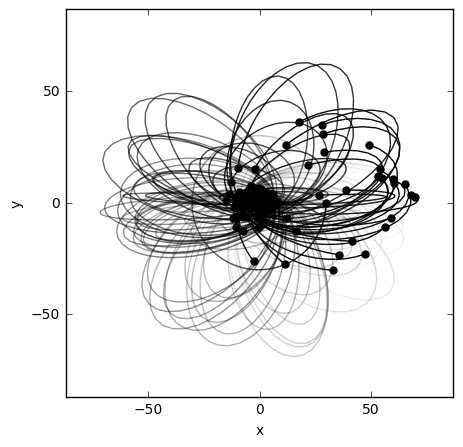

In [6]:
%matplotlib inline
fig = rebound.OrbitPlot(sim, trails=True)

Finally, let's simulate our system for and check that our final relative energy error is small. The energy error is a key measure of whether the integration was performed accurately or not. Usually anything below $10^{-5}$ is considered good. 

In [ ]:
sim.integrate(tmax)
dE = abs((sim.calculate_energy() - E0)/E0)
print dE